# Prospecção de Dados - Data Mining - DI/FCUL2022/2023

## Lab class TP04 [addendum from TP03]

# Dimensionality Reduction - CUR Decomposition

*A Data Mining Tutorial by Andre Falcao (DI/FCUL 2021-2023)*


## CUR decomposition

CUR decomposition is a process where a very large matrix (typically very sparse) is approximated with a product of 3 matrices, C, U and R. C and R are defined as:

* $C$ is a column matrix with as many columns as a predetermined amount. Each column is selected with a probability proportional to its importance, (measured as the sum of all elements) 
* $R$ is a Row matrix with as many rows as a predetermined amount. Each row is selected with a probability proportional to its importance, (measured as the sum of all elements) 

Matrices C and R are then updated with a factor inversely proportional to the square root of the product of their probability of selection with the number of rows/columns selected

As for the U Matrix, the approach followed here comes from [Mahoney and Drineas](https://www.pnas.org/doi/pdf/10.1073/pnas.0803205106) as it is sufficiently reliable for a variaty of situations

$$ U = C^{+} . A . R^{+}$$

As $C^+$ and $R^+$ are the Moore-Penrose pseudo-inverses of the $C$ and $R$ matrices.
Thus, the process for making a CUR decomposition is not too complex and requires one function that takes as input a data set and an desired number of components (`r`). It is needed one extra function that will compute the probabilities for each column and row to be selected for matrices C and R, respectively



### Interlude - What is the Pseudo Inverse,  and how to compute it?

Here is a bit of code to explain it

In [1]:
import numpy as np
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

def my_pinv(M):
    #do SVD
    U,S,V = np.linalg.svd(M, full_matrices=False)
    #make S+
    S_plus=np.diag(1/S)
    #compute the pseudo-inverse:
    M_plus = (U @ S_plus @ V).T
    return M_plus


print("Sample Matrix A")
A=np.array([1,0,3,4,5,1,9,5,5]).reshape([3,3])
print(A)
print("\nthis is the Pseudo Inverse (actually the real inverse!)")
A_plus=my_pinv(A)
print(A_plus)
print("\nand let's check to see if we get the identity")
print(A @ A_plus)
print("\nsuccess!")

Sample Matrix A
[[1 0 3]
 [4 5 1]
 [9 5 5]]

this is the Pseudo Inverse (actually the real inverse!)
[[-0.36 -0.27  0.27]
 [ 0.2   0.4  -0.2 ]
 [ 0.45  0.09 -0.09]]

and let's check to see if we get the identity
[[ 1.  0. -0.]
 [-0.  1.  0.]
 [-0. -0.  1.]]

success!


In the example below we will not use this implementation but rather the numpy embedded implementation

### Algorithmic CUR

For CUR decomposition we just require 3 functions:
* `get_probs` - computes the pobability of selecting a column
* `get_columns` - that will retrieve a number of `r` columns from a matrix, according to their probabilities and will scale them according to each column probability and value `r`
* `CUR` - computes the CUR decomposition for a matrix and a number of selected rows and columns using the above principles

In [2]:


def get_columns(DM, r, probs):
    size = DM.shape[1]
    idx = np.random.choice(size, size=r, p=probs)
    cols=DM[:, idx]
    c_factor=np.sqrt(probs[idx]*r )
    return cols / c_factor

def get_probs(DM):
    dm2 = DM**2
    r_sum = np.sum(dm2, 1)
    c_sum = np.sum(dm2, 0)
    tot = np.sum(r_sum)
    r_probs = r_sum / tot
    c_probs = c_sum / tot
    return r_probs, c_probs

def CUR(DM, r):
    r_probs, c_probs = get_probs(DM)
    C = get_columns(DM, r, c_probs)
    R = get_columns(DM.T, r, r_probs).T
    U = np.linalg.pinv(C) @ DM @  np.linalg.pinv(R)
    return C, U, R



To see how actually CUR works let's load a sample image as a basic matrix

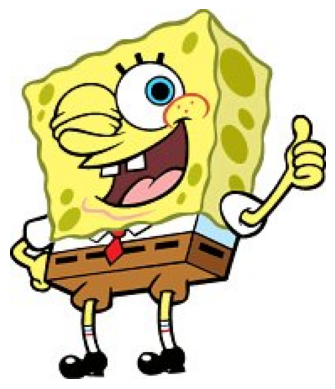

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
im = Image.open("sbob.jpg")

plt.imshow(im)
plt.axis('off')
plt.show()

Even though we could use with the 3 channels, for the purpose of this presentation, let's use the monochrome image (grayscale). Also, let's put it inverted and much less denser by increasing the number of black pixels

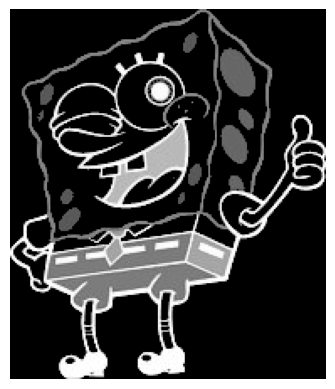

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

gray=rgb2gray(np.asarray(im))

igray = 1-gray/256
igray[igray<.3]=0

plt.imshow(igray, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()


Lets do a CUR decomposition of the image and examine the 3 components, where it is possible to examine the sparisty of the C and R matrices

C matrix (220, 50)


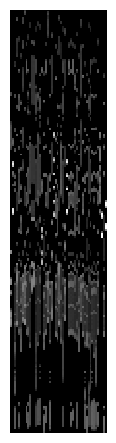

U matrix (50, 50)


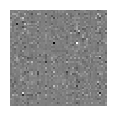

R matrix (50, 188)


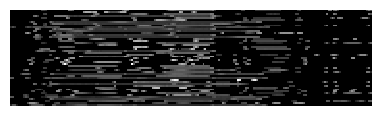

In [30]:
def display_matrix(M, scale=4):
    H, W=M.shape
    S=scale*100
    plt.figure(figsize=[10*W/S, 10*H/S])
    plt.imshow(M, cmap=plt.get_cmap('gray'), interpolation="none")
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()
    
C, U, R = CUR(igray, 50)
print("C matrix", C.shape)
display_matrix(C)
print("U matrix", U.shape)
display_matrix(U)
print("R matrix", R.shape)
display_matrix(R)

Now let's reconstruct the image using only these 50 components. Ploease note that here we are not taking advantage of the decomposition main benefits, which is to have the C and R matrices as sparse matrices, yet it is not difficult to see that with only 50 components, the basis of the image structure is being captured

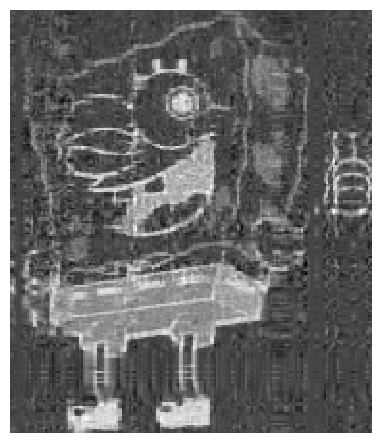

In [31]:
new= C @ U @ R
display_matrix(new)


Now let's examine how close are we to the original image as we increase the size of the r parameter. Note that r can be much bigger than the original matrix

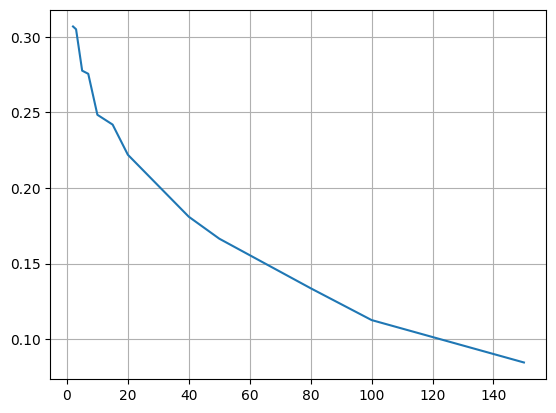

In [16]:
X=np.array([2,3,5,7,10, 15, 20, 40, 50, 80, 100, 150])
RMSEs_cur=[]
for r in X:
    C, U, R = CUR(igray, r)
    new= C @ U @ R
    rmse=np.sqrt(((igray-new)**2).mean())
    RMSEs_cur.append(rmse)
plt.plot(X, RMSEs_cur)
plt.grid()
plt.show()


### A comparison with SVD

SVD should shine in this example as it should, by definition, be able to capture all the information

First let's look at image reconstruction with the Full U, S and V matrices

S: (220, 188)
U: (188,)
V: (188, 188)


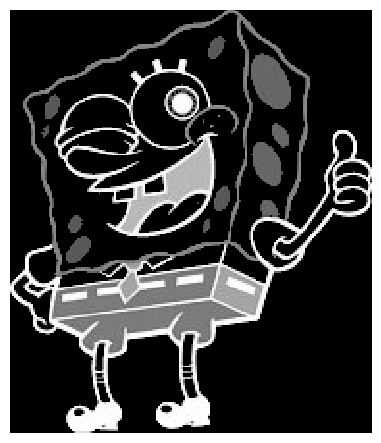

In [17]:
U,S,Vh=np.linalg.svd(igray, full_matrices=False)
print("S:", U.shape)
print("U:", S.shape)
print("V:", Vh.shape)

new2= U @ np.diag(S) @ Vh
display_matrix(new2)

Now let's test the same decomposition as for CUR using a `r` value of 50

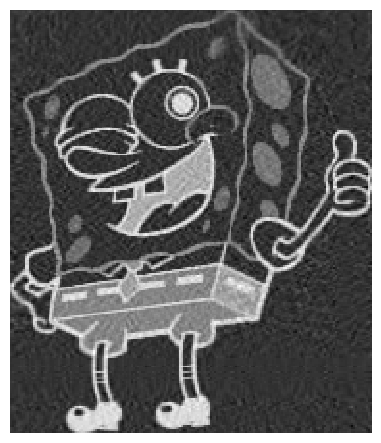

In [18]:
r=50
Ur  = U[:, :r]
Sr  = S[:r]
Vhr = Vh[:r, :]
new2= Ur @ np.diag(Sr) @ Vhr
display_matrix(new2)

U matrix (220, 50)


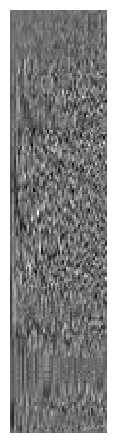

S matrix (50,)


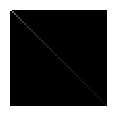

V matrix (50, 188)


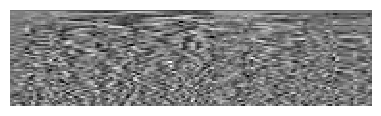

In [19]:

print("U matrix", Ur.shape)
display_matrix(Ur)
print("S matrix", Sr.shape)
display_matrix(np.diag(Sr))
print("V matrix", Vhr.shape)
display_matrix(Vhr)


The much better quality of SVD shines here, and the image is near perfect

Let's compare both approaches in terms of difference to the original matrix

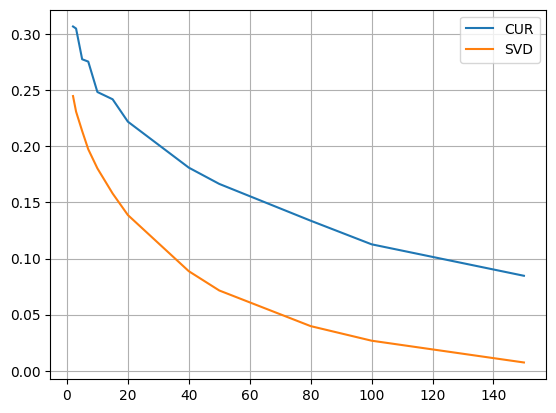

In [20]:

X=np.array([2,3,5,7,10, 15, 20, 40, 50, 80, 100, 150])
RMSEs_svd=[]
for r in X:
    Ur  = U[:, :r]
    Sr  = S[:r]
    Vhr = Vh[:r, :]
    new= Ur @ np.diag(Sr) @ Vhr
    rmse=np.sqrt(((igray-new)**2).mean())
    RMSEs_svd.append(rmse)
RMSEs_svd=np.array(RMSEs_svd)
RMSEs_cur=np.array(RMSEs_cur)
plt.plot(X, RMSEs_cur, label="CUR")
plt.plot(X, RMSEs_svd, label="SVD")
plt.legend()
plt.grid()
plt.show()


